In [1]:
#| echo: false
#| output: false
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tf.keras.layers
tfpl = tfp.layers

import matplotlib.pyplot as plt
plt.style.use('bmh')

2023-11-12 18:02:42.270851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Stochastic differential equations
A [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) is a sequence of random variables $X_t$ indexed by a time parameter $t$ that can be discrete or continuous. The dynamics of a continuous process is often described by a [stochastic differential equation](https://en.wikipedia.org/wiki/Stochastic_differential_equation) (SDE) of the form

$$
dX_t = \mu(X_t, t)dt + \sigma(X_t, t)dW_t,
$$

where $\mu(X, t)$ is called the drift and $\sigma(X, t)$ the volatility.

In statistical physics, the random variable $X_t$ can describe the positions at time $t$ of a population of molecules swimming around in water, bumping randomly into smaller molecules following a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) $W_t$. In finance, $X_t$ can describe the uncertainty over an asset price in the future due to the random behavior of market participants.

Solving this SDE means finding the probability distribution of $X_t$ for $t>0$, given the initial distribution of $X_{t=0}$. This can be done by specifying the probability density function (PDF) $p(x; t)$ for $t>0$ given the initial PDF $p(x; t=0)$ (here the semicolon indicates that $x$ is the value realized by the random variable, and $t$ the time parameter that indexes the distributions).

For certain special cases of $\mu(X, t)$ and $\sigma(X, t)$, the SDE can be solved explicitly (see these [lecture notes](https://ethz.ch/content/dam/ethz/special-interest/mavt/dynamic-systems-n-control/idsc-dam/Lectures/Stochastic-Systems/SDE.pdf) for some examples). In general, one has to rely on numerical methods.

## Euler-Maruyama
The [Euler–Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) is probably the most flexible one. It generates approximated samples of the process $X_t$ at discretized time steps $t_1, \dots, t_N$,

$$
X_{i+1} = X_i + \mu(X_i, t_i)\Delta t_i + \sigma(X_i, t_i)\,\sqrt{\Delta t_i}\, Z_i,
$$

where every $Z_i$ is drawn from a standard normal distribution.

In TensorFlow Probability, this method can be implemented as a `tfd.MarkovChain` distribution. The following code snippet illustrates it with a geometric Brownian motion.

In [12]:
drift = .1
volatility = .2

n_steps = 501
time = tf.linspace(0., 10, n_steps)
time_step = np.mean(np.diff(time))

geom_brownian_motion = tfd.MarkovChain(
            initial_state_prior=tfd.Deterministic(1.),
            transition_fn=lambda _, x: tfd.Normal(
                loc=x + x * drift * time_step,
                scale=x * volatility * tf.sqrt(time_step)),
            num_steps=n_steps,
            name='geometric_brownian_motion')

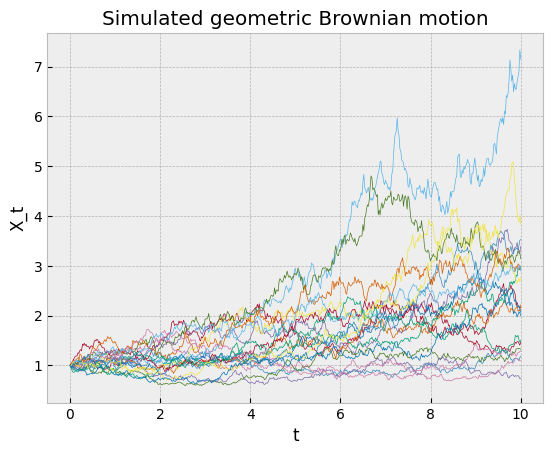

In [13]:
#| echo: false
plt.plot(time, tf.transpose(geom_brownian_motion.sample(20)), linewidth=.5)
plt.title('Simulated geometric Brownian motion')
plt.xlabel('t')
plt.ylabel('X_t')
plt.show()

Sometimes, one is interested only in expected values of the form

$$
\mathbb{E}\left[f(X_t)\right] = \int f(x)\,p(x; t)\,\mathrm{d}x,
$$

for instance in asset pricing problems. Samples generated by the Euler-Maruyama methods can be used in Monte Carlo estimates

$$
\mathbb{E}\left[f(X_t)\right] \approx \sum_k f(\hat X_{t, k}),
$$

where the sum is taken over several realizations of the stochastic numerical integration.

Other times, one needs to know the probability density function at a given time $t$, for instance in inference problems with models that have a stochastic process component. Markov chains could provide that in theory, but at the expense of marginalizing out all the intermediate steps.

## Fokker-Planck
Physicists came up with an alternative solution by deriving a partial differential equation (PDE) for $p(x;t)$ that is equivalent to the SDE, the [Fokker-Planck](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation) equation

$$
\frac{\partial p(x; t)}{\partial t} = -\frac{\partial}{\partial x}[\mu(x, t)p(x; t)] + \frac{1}{2}\frac{\partial^2}{\partial x^2}[\sigma^2(x, t)p(x; t)].
$$

It describes how the initial distribution $p(x;0)$ is shifting under the influence of the drift term and diffusing because of the volatility term. For the non-physicists who want to try this at home, $p(x;0)$ could indicate the position of a tea bag in a cup of hot water, $\mu(x, t)$ could describe how the water has been stirred, and $\sigma(x, t)$ would depend on the thermal agitation of the water.

These PDEs are usually solved numerically. This can be difficult when $\mu(X, t)$ renders the equation [stiff](https://en.wikipedia.org/wiki/Stiff_equation) (this happens in models of noisy microcircuits) or in high-dimensional problems (for instance models of the joint distribution of stock prices in large markets).

A limitation of this modeling approach is the difficulty to sample from a distribution given by an arbitrary probability density function. This requires specialized algorithms, so in practice it is probably better to rely on Euler-Maruyama methods for sampling, and Fokker-Planck equations for density evaluation. Furthermore, the log-densities should be compatible with automatic differentiation to be useful in probabilistic inference algorithms, which is not always straightforward with PDE solvers.

## Probabilistic machine learning
Probabilistic machine learning provides a third approach, where one gets a model that can both generate new samples and evaluate densities in an a framework supporting automatic differentiation. The idea is to first generate training data with the Euler-Maruyama method, and then use machine learning to fit a probability distribution parameterized by a neural network to this synthetic data. The training objective is the conditional density estimation of the synthetic training data. This distribution should both be convenient to sample from and have a density that can be evaluated easily.

Such distributions can be constructed with [autoregressive normalizing flows](https://arxiv.org/abs/1705.07057) parameterized by conditional [masked autoregressive networks](https://arxiv.org/abs/1502.03509). In a nutshell, a normalizing flow deforms a normal distribution into a more generic one through an invertible mapping. This mapping can be implemented as a neural network, provided the network is invertible, and the autoregressive condition imposed by masking certain weights ensures just that. Moreover, these autoregressive networks can accept conditional variables, so that they can estimate the parametric density $p(x; t)$ if $t$ is passed to the model as a conditional variable.

In [32]:
# Generate synthetic training data
n = 200
s = geom_brownian_motion.sample(n)

t = tf.reshape(tf.stack(s.shape[0]*[time], axis=0)[:,1:], (-1, 1))
X = tf.reshape(s[:, 1:], (-1, 1))

# Conditional density estimation with MADE.
made = tfb.AutoregressiveNetwork(
  params=2,
  hidden_units=[32, 32],
  event_shape=(1,),
  conditional=True,
  kernel_initializer=tfk.initializers.VarianceScaling(0.1, seed=42),
  conditional_event_shape=(1,)
)

distribution = tfd.TransformedDistribution(
  distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.),
                          sample_shape=(1,)),
  bijector= tfb.Chain([tfb.Exp(), tfb.MaskedAutoregressiveFlow(made, name='maf')])
)

# Construct and fit a model.
X_ = tfkl.Input(shape=(X.shape[-1],), dtype=tf.float32)
t_ = tfkl.Input(shape=(t.shape[-1],), dtype=tf.float32)
log_prob_ = distribution.log_prob(
  X_, bijector_kwargs={'maf': {'conditional_input': t_}})
model = tfk.Model([X_, t_], log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003),
              loss=lambda _, log_prob: -log_prob)

batch_size = 500

history = model.fit(x=[X, t],
                    y=np.zeros((X.shape[0], 0), dtype=np.float32),
                    batch_size=batch_size,
                    epochs=40,
                    steps_per_epoch=X.shape[0] // batch_size,
                    shuffle=True,
                    verbose=False)

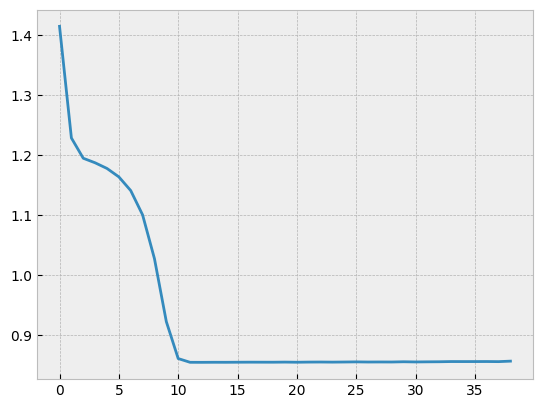

In [33]:
#| echo: false
#| output: false
plt.plot(history.history['loss'][1:])

Here the autoregressive flow was chained with an exponential map to constrain its output to the support of the target distribution, $\mathbb{R}_{>0}$. Note how the conditional variable $t$ is passed to the `log_prob` method in a dictionary of keyword arguments to make sure it ends up in the right neural network.

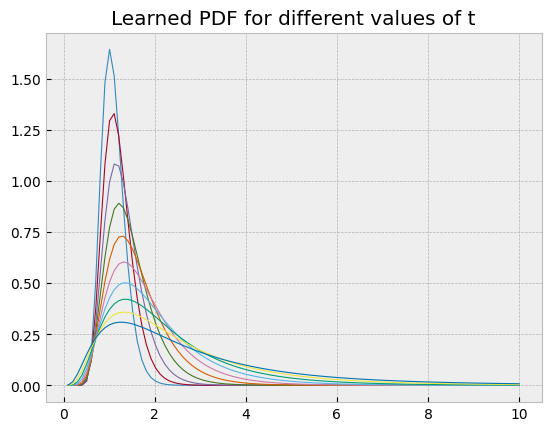

In [34]:
#| echo: false
sample_space = tf.linspace(0.0, 10, 100)
for i in range(10):
    density = distribution.prob(sample_space[...,None], bijector_kwargs={'maf': {'conditional_input': (i+1)*tf.ones((1,1), tf.float32)}})
    plt.plot(sample_space, density, linewidth=.8)
plt.title('Learned PDF for different values of t')
plt.show()

These learned probability density functions can be compared with the true solution

$$
X_t = X_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}
$$

of the geometric Brownian motion SDE, which follows a log-normal distribution. This was the main reason for using this example.

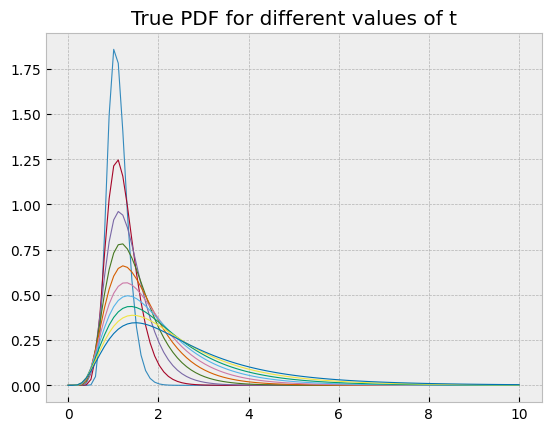

In [35]:
#| echo: false
for i in range(1, 11):
    dist = tfd.LogNormal(i * (drift - volatility**2/2), tf.sqrt(i*1.) * volatility)
    plt.plot(sample_space, dist.prob(sample_space), linewidth=.8)
plt.title('True PDF for different values of t')
plt.show()

In the same plot, one can see they more or less agree.

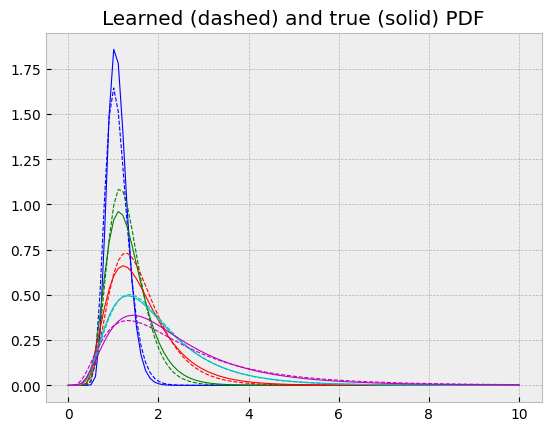

In [36]:
#| echo: false
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for i in range(5):
    density = distribution.prob(sample_space[...,None], bijector_kwargs={'maf': {'conditional_input': (2*i+1)*tf.ones((1,1), tf.float32)}})
    plt.plot(sample_space, density, '--', linewidth=.8, color=colors[i])
    dist = tfd.LogNormal((2*i+1) * (drift - volatility**2/2), tf.sqrt((2*i+1)*1.) * volatility)
    plt.plot(sample_space, dist.prob(sample_space), linewidth=.8, color=colors[i])
plt.title('Learned (dashed) and true (solid) PDF')
plt.show()

## Simulation based inference
For the sake of example, the model presented here only accepted the time $t$ as a conditional variable, and the initial value was deterministic. One can generate richer training data by drawing the drift and volatility parameters as well as the initial value from proposal distributions and pass them as further conditional variables to the model. This makes it possible to learn a parameterized conditional distribution $p(x;t\vert \mu, \sigma, x_0)$ (here $t$ is the parameter indexing the distributions, and $\mu$, $\sigma$ and $x_0$ are conditioning it). This is particularly useful if the ultimate goal is to perform Bayesian inference of the parameters $\mu$, $\sigma$ or $x_0$ from experimental data. Or one can use it to construct a transition function $p(x; t\vert t_0; x_0)$ of a Markov chain if the problem involves discrete observations of an underlying stochastic process.

The general methodology applied here falls under the scope of [simulation based inference](https://simulation-based-inference.org/). This growing field of computational statistics addresses problems where a model can accurately simulate data, but it has no tractable [likelihood](https://en.wikipedia.org/wiki/Likelihood_principle) function that would enable statistical inference. The Euler-Maruyama method is a good example as deriving a likelihood function would require integrating over all intermediate time steps. As a workaround, some simulation based inference algorithms propose to derive a surrogate likelihood function through machine learning (that was discussed in a previous [post](https://ybarmaz.github.io/blog/posts/2023-07-14-Neural-likelihood-estimation.html)), which is what was done here with the conditional masked autoregressive flow.